# Первое задание

In [1]:
import pandas as pd
import re

In [2]:
filepath = 'events filters к тестовому Product Analyst Q1 2024.csv'
df = pd.read_csv(filepath)
df.head(10)

,event_category,event_action,event_label,total_events,unique_events
0,city_landing,price_button_submit,Tula / Показать предложения (11),8,7
1,city_landing,price_button_submit,Sochi / Показать предложения (39),12,10
2,city_landing,search-tools-button_open,Penza / Сортировка,2,2
3,city_landing,filters-categories_click,Gelendzhik / ЭКСКУРСИИ В ГЕЛЕНДЖИКЕ ЦЕНЫ,1,1
4,city_landing,price_button_submit,Moscow / Показать предложения (345),2,2
5,city_landing,clear_filter_mobile,Vienna,12,11
6,city_landing,start_date_click,Vilnius,9,4
7,city_landing,ticket-type_checkbox,Irkutsk / Мини-группа,29,26
8,city_landing,price_button_submit,Vladivostok / Показать предложения (28),3,3
9,city_landing,filters-categories_click,Krakow / Необычные,3,3


Сначала с помощью регулярного выражения создадим ещё один столбец city, в нем будут соответственно названия городов из event_label без доп. информации, которая может идти после символа "/".

In [4]:
df['city'] = df['event_label'].apply(lambda x: re.split(r' / ', str(x))[0])
df.head()

,event_category,event_action,event_label,total_events,unique_events,city
0,city_landing,price_button_submit,Tula / Показать предложения (11),8,7,Tula
1,city_landing,price_button_submit,Sochi / Показать предложения (39),12,10,Sochi
2,city_landing,search-tools-button_open,Penza / Сортировка,2,2,Penza
3,city_landing,filters-categories_click,Gelendzhik / ЭКСКУРСИИ В ГЕЛЕНДЖИКЕ ЦЕНЫ,1,1,Gelendzhik
4,city_landing,price_button_submit,Moscow / Показать предложения (345),2,2,Moscow


In [9]:
# Рассмотрим все уникальные события в поле event_action

df['event_action'].unique()

array(['price_button_submit', 'search-tools-button_open',
       'filters-categories_click', 'clear_filter_mobile',
       'start_date_click', 'ticket-type_checkbox', 'dates_filter_mobile',
       'price_third', 'Page Visit', 'end_date_click', 'price_second',
       'pay-type_checkbox', 'price_button_close', 'price_first'],
      dtype=object)

## Первый вопрос:

**Сколько людей пользуются фильтрами?** 

Объясню свой подход

Что считать за использование фильтров, нам дана разного рода информация: 
1. Об открытии окна с фильтрами/сортировками/категориями: search-tools-button_open
2. О количестве применений фильтров: price_button_submit
3. О активации чекбоксов разных фильтров (н-р, 'start_date_click' или 'ticket-type_checkbox')

Суммировать третье мы не можем, так как непонятно как соотносятся данные, 3 уникальных события оплаты на месте и 5 тотал собыйти оплаты на месте означают что были пользователи, которые дезактивировали чекбокс и выбрали его снова.
Если в событиях есть 3 уник. события оплаты на месте ('pay-type_checkbox') и 6 уник. событий активации чекбокса типа группы ('ticket-type_checkbox'), то я это вижу как один и тот же пользователь для каждого из этих событий считается уникальным. То есть если он сначала активировал один чекбокс, а потом другой и обе активации были совершены в первый раз в рамках сессии, то для обоих событий он будет считаться уникальным, надеюсь понятно объяснила :)

Так вот, взять за ответ -- количество применений фильтров (price_button_submit) было бы просто :)

Данные об открытиии окошка не очень помогают, пользователи могут открыть окошко, но не применить ни один фильтр, а еще в поле event_label для этих событий данные грязные, я хотела попытаться по event_label разделить данные на фильтры, сортировки и чекбоксы, но не уверена была в своем решении, некоторые данные, по типу: "Выбрано: 2" непонятно к чему относить.

Итого: 
Из множества событий извлекла те, которые триггерятся при активации чекбоксов в окошке с фильтрами и посчитала количество уникальных событий активации.

In [124]:
# Простой вариант
using_filters = df[df['event_action'] == 'price_button_submit']['unique_events'].sum()
using_filters

63063

Решение, которое описано в "Итого:" 

In [10]:
filteres = ['start_date_click', 'end_date_click', 'ticket-type_checkbox', 'dates_filter_mobile', 'price_first', 'price_second', 'price_third',
'pay-type_checkbox']
filteres_using = df[df['event_action'].isin(filteres)].groupby('event_action')['unique_events'].sum()
filteres_using

event_action
dates_filter_mobile     10272
end_date_click          11738
pay-type_checkbox        5465
price_first              6676
price_second             1995
price_third               595
start_date_click        14501
ticket-type_checkbox    17918
Name: unique_events, dtype: int64

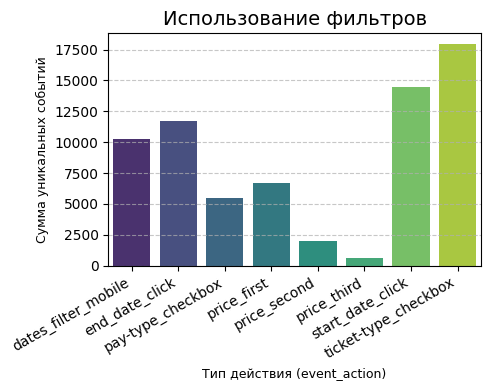

In [144]:
import seaborn as sns

# Преобразование Series в DataFrame
filteres_using_df = filteres_using.reset_index()

# Построение графика
plt.figure(figsize=(5, 4)) 
sns.barplot(data=filteres_using_df, x='event_action', y='unique_events', palette='viridis')

plt.title('Использование фильтров', fontsize=14)
plt.xlabel('Тип действия (event_action)', fontsize=9)
plt.ylabel('Сумма уникальных событий', fontsize=9)
plt.xticks(rotation=30, ha='right', fontsize=10) 
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout() 

plt.show()


## Второй вопрос
**В каких городах фильтрами пользуются больше? в каких меньше?**


Рассматриваем события price_button_submit, сгруппированные по городам

In [149]:
filteres_using_by_cities = df[df['event_action'] == 'price_button_submit'].groupby('city')['unique_events'].sum()
filteres_using_by_cities_sorted = filteres_using_by_cities.sort_values(ascending=False)

minimal = filteres_using_by_cities_sorted[filteres_using_by_cities_sorted == 1]
filteres_using_by_cities_sorted.head(10), minimal


(city
 Kaliningrad         5222
 Saint Petersburg    5028
 Moscow              3176
 Sochi               2909
 Istanbul            2357
 Dubai               2095
 Budapest            1843
 Kazan               1839
 Anapa               1619
 Sharm-el-Sheikh     1440
 Name: unique_events, dtype: int64,
 city
 Montreal           1
 Bremen             1
 Palenque           1
 Nevyansk           1
 Baden-Baden        1
 service-city       1
 Wiesbaden          1
 bogolyubovo        1
 Vicenza            1
 Partenit           1
 Auckland           1
 Padova             1
 Parma              1
 Bibione            1
 Orekhovo-Zuyevo    1
 Bethlehem          1
 Amman              1
 Belokurikha        1
 Antwerp            1
 Bamberg            1
 San Sebastian      1
 Cambodia           1
 Sviyazhsk          1
 Scotland           1
 Klin               1
 Kobuleti           1
 Rzhev              1
 Izmir              1
 Izborsk            1
 Sigulda            1
 Innsbruck          1
 Singapore

Для наглядности ещё можно построить график распределения

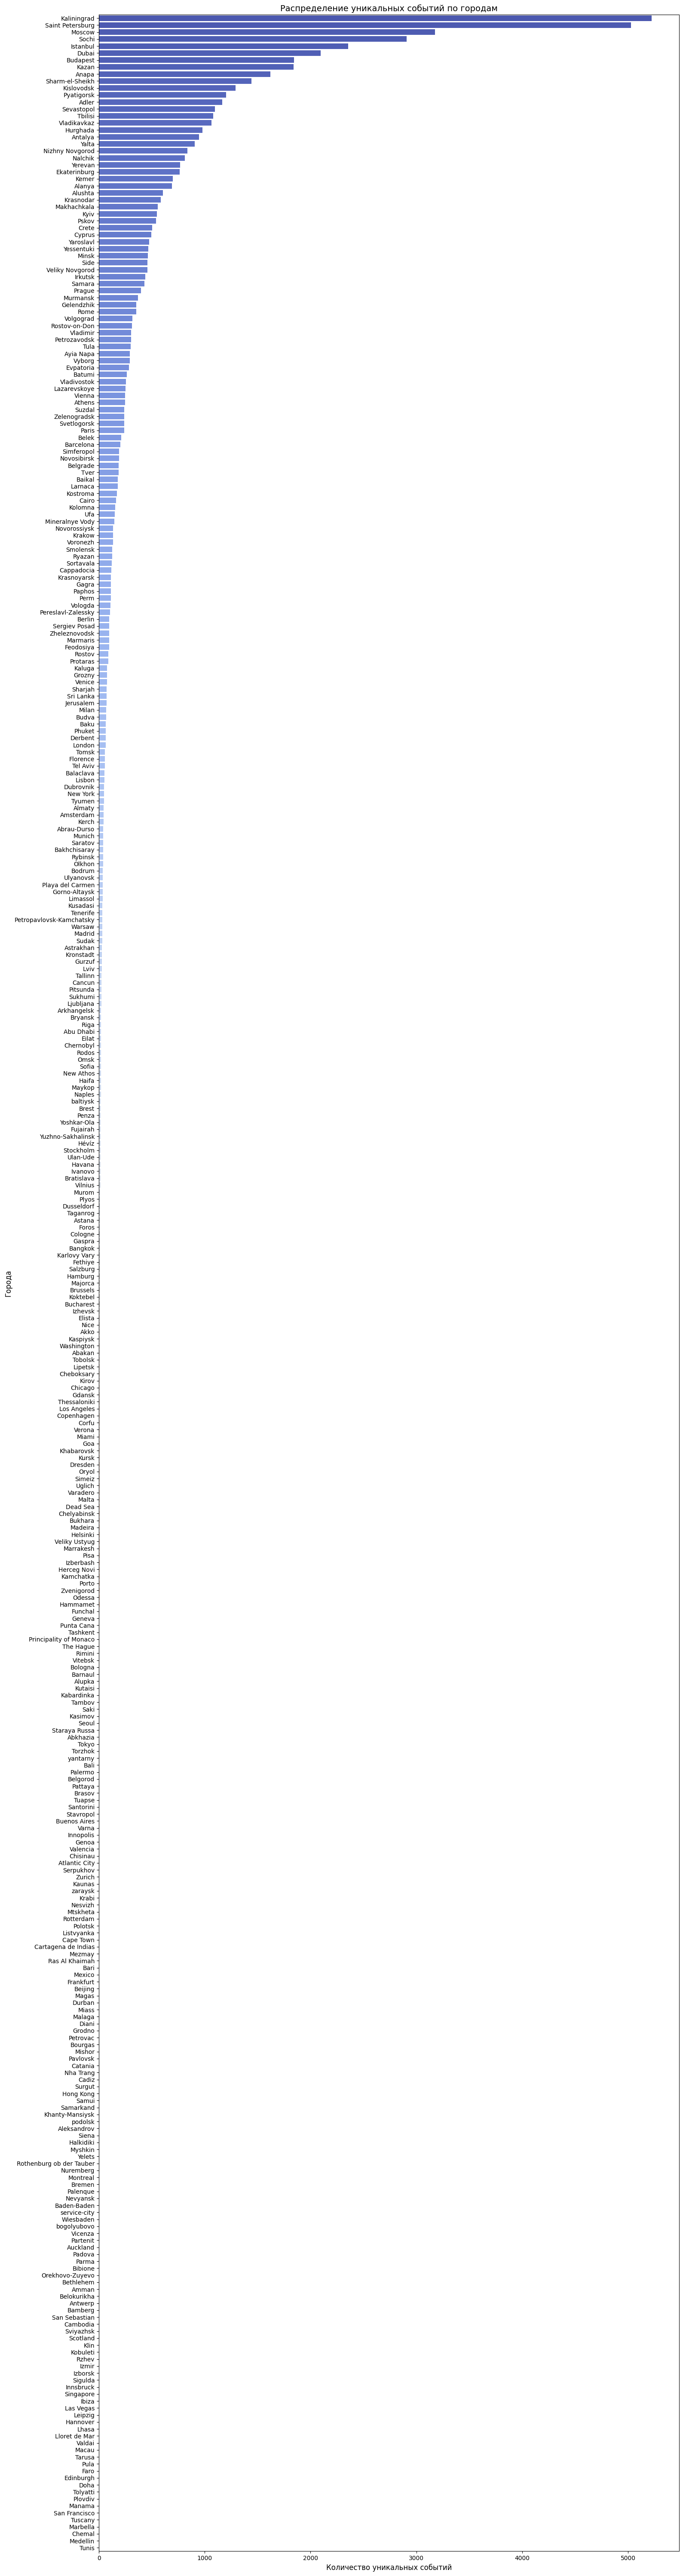

In [150]:
import seaborn as sns
import matplotlib.pyplot as plt

cities = filteres_using_by_cities_sorted.index
values = filteres_using_by_cities_sorted.values

data = pd.DataFrame({'City': cities, 'Unique Events': values})

plt.figure(figsize=(16, 60))

# Строим горизонтальный бар-чарт
sns.barplot(
    data=data,
    y='City',
    x='Unique Events',
    palette='coolwarm'
)

plt.xlabel('Количество уникальных событий', fontsize=12)
plt.ylabel('Города', fontsize=12)
plt.title('Распределение уникальных событий по городам', fontsize=14)

plt.tight_layout()

plt.show()


## Третий вопрос

**Какие разделы фильтров наиболее востребованы? “фильтры”, “сортировка”, “категории”? (по описанию в event label разделить сортировку и категории)**

Активация чекбокса с категориями ('filters-categories_click'), категории -- это те, что в фильтрах или на основном экране? -- такой вопрос стоял в процессе решения.

Если я правильно понимаю, на основном экране есть место для выбора категорий, и выбрать категорию можно там сразу, 
а еще категории есть в окне с фильтрами.

Аналогично с открытиме окна фильтров/сортировок/категорий ('search-tools-button_open') -- непонятно это разделение, поэтому я рассмотрела filters-categories_click.
Там было хорошее описание в event_label (небольшое число уникальных значений для дополнительного описания, после символа / и нигде не было пустых значений)
Смогла найти активации чекбоксов для событий активации сортировки (фильтр событий содержащих слово "Сначала"), 
А остальные события -- это активации категорий.

Возможно такое что при активации категории на главном окне генерируется сразу два события -- search-tools-button_open и filters-categories_click. А про фильтр категорий (в окошке с фильтрами доступен фильтр категорий) ничего не сказано в задании. Но с другой стороны в описании кнопки search-tools-button_open говорится, что речь идет об активации отдельно фильтров/категорий/сортировок. Поэтому здесь все-таки речь идет о категориях на основном экране. 

Насчет активаций чекбоксов категорий в событиях filters-categories_click, кажется, что здесь речь идет о категориях на главном экране, потому что сортировки находятся там же, было бы странно смешивать события для сортировок, которые находятся на основном экране с фильтром категорий, который находится в окошке с фильтрами, воть :)
Ещё аргументом против того, что в событии filters-categories_click речь идет не о событиях в окошке с фильтрами может быть, то что активация чекбоксов в окошке с фильтрами еще не означает их применение, в то время как
активация чекбокса в сортировке и категориях на главной странице автоматически применяет выбранный чекбокс.

Поэтому при анализе востребованности фильтров / сортировок / категорий я бы сравнивала полученную информацию с price_button_submit.

В фильтрах можно взять среднее значение, медианное


In [61]:
# Создаем новый столбец 'sort_filter'
df['sort_filter'] = (df['event_action'] == 'filters-categories_click') & (df['event_label'].str.contains("Сначала", na=False))

df[df['sort_filter']].head(20)
df.head()

,event_category,event_action,event_label,total_events,unique_events,city,sort_filter,categories_filter
0,city_landing,price_button_submit,Tula / Показать предложения (11),8,7,Tula,False,False
1,city_landing,price_button_submit,Sochi / Показать предложения (39),12,10,Sochi,False,False
2,city_landing,search-tools-button_open,Penza / Сортировка,2,2,Penza,False,False
3,city_landing,filters-categories_click,Gelendzhik / ЭКСКУРСИИ В ГЕЛЕНДЖИКЕ ЦЕНЫ,1,1,Gelendzhik,False,True
4,city_landing,price_button_submit,Moscow / Показать предложения (345),2,2,Moscow,False,False


In [62]:
# Создаем новый столбец 'categories_filter'
df['categories_filter'] = (df['event_action'] == 'filters-categories_click') & (~df['event_label'].str.contains("Сначала", na=False))

df[df['categories_filter']].head(20)
df.head()

,event_category,event_action,event_label,total_events,unique_events,city,sort_filter,categories_filter
0,city_landing,price_button_submit,Tula / Показать предложения (11),8,7,Tula,False,False
1,city_landing,price_button_submit,Sochi / Показать предложения (39),12,10,Sochi,False,False
2,city_landing,search-tools-button_open,Penza / Сортировка,2,2,Penza,False,False
3,city_landing,filters-categories_click,Gelendzhik / ЭКСКУРСИИ В ГЕЛЕНДЖИКЕ ЦЕНЫ,1,1,Gelendzhik,False,True
4,city_landing,price_button_submit,Moscow / Показать предложения (345),2,2,Moscow,False,False


In [23]:
count_sorting = df[df['sort_filter'] == True]['unique_events'].sum()
count_sorting

15604

In [24]:
count_categories = df[df['categories_filter'] == True]['unique_events'].sum()
count_categories

46935

In [63]:
count_filters = df[df['event_action'] == 'price_button_submit']['unique_events'].sum()
count_filters

63063

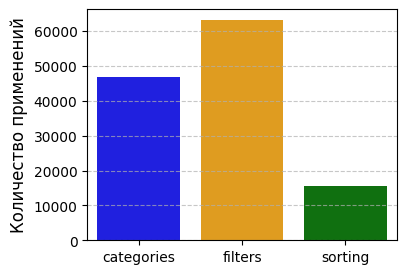

In [152]:
# Данные
categories = ['categories', 'filters', 'sorting']
values = [count_categories, count_filters, count_sorting] 

# Создаем DataFrame для использования в Seaborn
import pandas as pd
data = pd.DataFrame({
    'Categories': categories,
    'Values': values
})

plt.figure(figsize=(4, 3))
sns.barplot(x='Categories', y='Values', data=data, palette=['blue', 'orange', 'green'])
plt.title('', fontsize=14)
plt.xlabel('', fontsize=12)
plt.ylabel('Количество применений', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


Найдем средние и медианные значения для количества применений фильтров/сортировок и категорий

In [94]:
# Группируем по городам, суммируем unique_events
grouped_by_city_filteres = df[df['event_action'] == 'price_button_submit'].groupby('city')['unique_events'].sum()
median_filters = grouped_by_city_filteres.median()

mean_filters = grouped_by_city_filteres.mean()
print(f'Median: {round(median_filters, 2)} Mean: {round(mean_filters, 2)}')

Median: 11.0 Mean: 173.73


Мединана сильно отклоняется от среднего значения, значит в данных есть выбросы. Можно построить график распределения количества использований фильтров. 

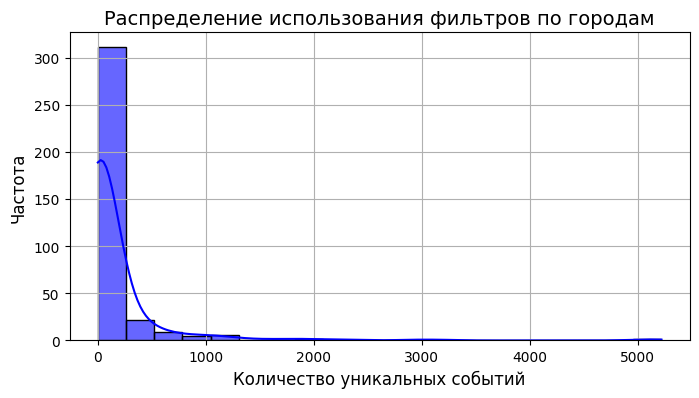

In [154]:
# Создание графика
plt.figure(figsize=(8, 4))

sns.histplot(grouped_by_city_filteres, kde=True, bins=20, color='blue', alpha=0.6)
plt.title('Распределение использования фильтров по городам', fontsize=14)
plt.xlabel('Количество уникальных событий', fontsize=12)
plt.ylabel('Частота', fontsize=12)
plt.grid(True)

plt.show()


По горизонтали число уникальных событий у городов. По вертикали частота встречаемости стольких уникальных событий. Видим, что график скошен. Большое количество городов, в которых один раз был применен фильтр. 
Это объясняет разницу в медиане и среднем значении.

Для сортировок и категорий графики имеют такой же характер.
Поэтому вывод о востребованности можно сделать по медиане и среднему значению и общему количеству, для фильтров эти показатели выше чем для сортировок и категорий, поэтому можно сказать, что фильтры наиболее востребованны.

In [103]:
grouped_by_city_sorting = df[df['sort_filter'] == True].groupby('city')['unique_events'].sum()
median_sorting = grouped_by_city_sorting.median()
mean_sorting = grouped_by_city_sorting.mean()
print(f'Median: {round(median_sorting, 2)} Mean: {round(mean_sorting, 2)}') 

Median: 8.0 Mean: 52.01


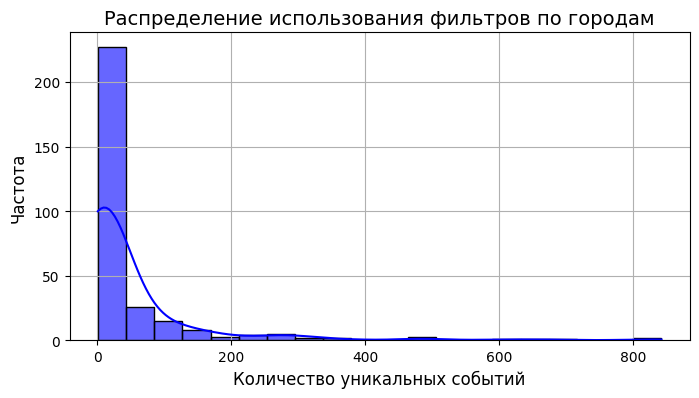

In [107]:
# Создание графика
plt.figure(figsize=(8, 4))

sns.histplot(grouped_by_city_sorting, kde=True, bins=20, color='blue', alpha=0.6)

plt.title('Распределение использования фильтров по городам', fontsize=14)
plt.xlabel('Количество уникальных событий', fontsize=12)
plt.ylabel('Частота', fontsize=12)
plt.grid(True)

plt.show()


In [97]:
grouped_by_city_categories = df[df['categories_filter'] == True].groupby('city')['unique_events'].sum()
median_categories = grouped_by_city_categories.median()
mean_categories = grouped_by_city_categories.mean()

print(f'Median: {round(median_categories, 2)} Mean: {round(mean_categories, 2)}') 

Median: 10.0 Mean: 167.62


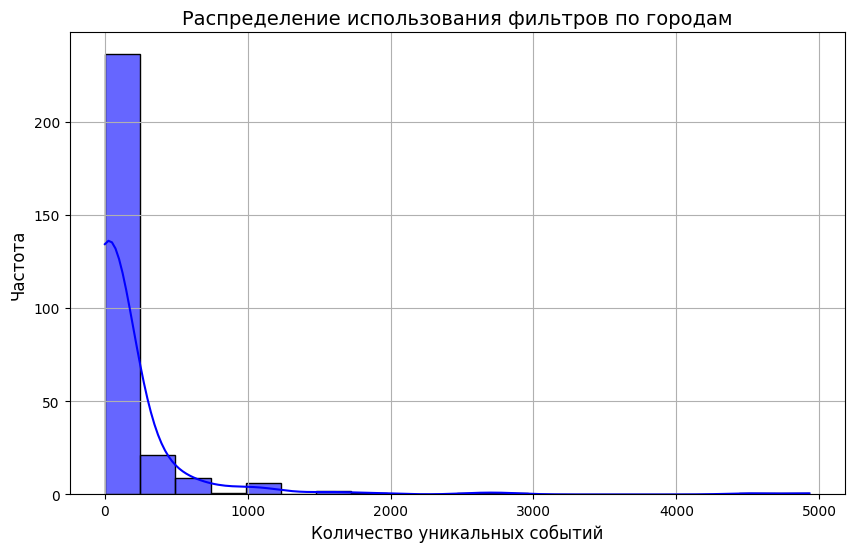

In [101]:
plt.figure(figsize=(10, 6))

sns.histplot(grouped_by_city_categories, kde=True, bins=20, color='blue', alpha=0.6)

plt.title('Распределение использования фильтров по городам', fontsize=14)
plt.xlabel('Количество уникальных событий', fontsize=12)
plt.ylabel('Частота', fontsize=12)
plt.grid(True)

plt.show()


## Четвертый вопрос
Как часто люди пользуются выбором цены?

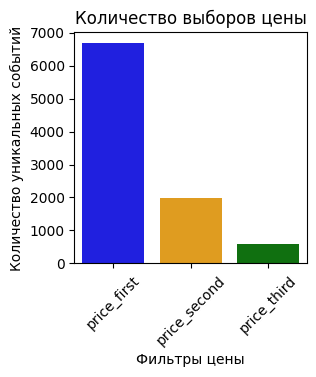

In [153]:
price_filters = ['price_first', 'price_second', 'price_third']
price_counts = df[df['event_action'].isin(price_filters)].groupby('event_action')['unique_events'].sum().reset_index()

plt.figure(figsize=(3, 3)) 
sns.barplot(x='event_action', y='unique_events', data=price_counts, palette=['blue', 'orange', 'green'])

plt.title('Количество выборов цены')
plt.xlabel('Фильтры цены')
plt.ylabel('Количество уникальных событий')
plt.xticks(rotation=45)
plt.show()
